In [ ]:
import torch
import torchvision
from torch import nn

# Еще немного о свертках

Conv2d: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

## Изменение размерностей при разных свертках

In [ ]:
def get_total_params(model):
  return sum(p.numel() for p in model.parameters())

In [ ]:
img_size = 128
in_channels = 3
out_channels = 10
img = torch.rand((1, in_channels, img_size, img_size))
print(f"Input shape: {img.shape}")

Input shape: torch.Size([1, 3, 128, 128])


In [ ]:
kernel_size, stride, padding = (3, 1, 1)
conv = nn.Conv2d(in_channels, out_channels,
              kernel_size=kernel_size, stride=stride, padding=padding)
res = conv(img)
res.shape

torch.Size([1, 10, 128, 128])

In [ ]:
# kernel_size, stride, padding
convs = [
    (1, 1, 0),  # img sizes don't change
    (2, 1, 0),  # img sizes changes -> [127, 127]
    (3, 1, 1),  # img sizes don't change
    (4, 1, 1),  # img sizes changes -> [127, 127]
    (5, 1, 2),  # img sizes don't change
    (6, 1, 1),  # img sizes changes -> [125, 125]
    (7, 1, 3),  # img sizes don't change

    (1, 2, 0),  # img sizes x2 down
    (2, 2, 0),  # img sizes x2 down
    (3, 2, 1),  # img sizes x2 down
    (4, 2, 1),  # img sizes x2 down
    (5, 2, 2), # img sizes x2 down
    (6, 2, 2), # img sizes x2 down
    (7, 2, 3),  # img sizes x2 down
]
for params in convs:
  kernel_size, stride, padding = params
  conv = nn.Conv2d(in_channels, out_channels,
                   kernel_size=kernel_size, stride=stride, padding=padding)
  res = conv(img)

  print(f'Config: {params} ({get_total_params(conv)} params) -> {res.shape}')

Config: (1, 1, 0) (40 params) -> torch.Size([1, 10, 128, 128])
Config: (2, 1, 0) (130 params) -> torch.Size([1, 10, 127, 127])
Config: (3, 1, 1) (280 params) -> torch.Size([1, 10, 128, 128])
Config: (4, 1, 1) (490 params) -> torch.Size([1, 10, 127, 127])
Config: (5, 1, 2) (760 params) -> torch.Size([1, 10, 128, 128])
Config: (6, 1, 1) (1090 params) -> torch.Size([1, 10, 125, 125])
Config: (7, 1, 3) (1480 params) -> torch.Size([1, 10, 128, 128])
Config: (1, 2, 0) (40 params) -> torch.Size([1, 10, 64, 64])
Config: (2, 2, 0) (130 params) -> torch.Size([1, 10, 64, 64])
Config: (3, 2, 1) (280 params) -> torch.Size([1, 10, 64, 64])
Config: (4, 2, 1) (490 params) -> torch.Size([1, 10, 64, 64])
Config: (5, 2, 2) (760 params) -> torch.Size([1, 10, 64, 64])
Config: (6, 2, 2) (1090 params) -> torch.Size([1, 10, 64, 64])
Config: (7, 2, 3) (1480 params) -> torch.Size([1, 10, 64, 64])


## Замена одной свертки несколькими

(Хаки из сети InceptionV3: https://browse.arxiv.org/pdf/1512.00567.pdf)

### Замена ядра (n, n) на ядра (n, 1) + (1, n)

<img src="https://www.pvsm.ru/images/2016/10/12/obzor-topologii-glubokih-svertochnyh-neironnyh-setei-30.png" alt="drawing" width="400"/>

In [ ]:
kernel_size, padding = (3, 1)

In [ ]:
conv = nn.Conv2d(in_channels, out_channels,
              kernel_size=kernel_size, padding=padding)
res = conv(img)
res.shape

torch.Size([1, 10, 128, 128])

In [ ]:
conv.weight # Out_c x in_c x ker_w x ker_h

In [ ]:
print(f'{get_total_params(conv)} params')

280 params


In [ ]:
conv1 = nn.Conv2d(in_channels, in_channels,
              kernel_size=(kernel_size, 1), padding=(padding, 0))
conv2 = nn.Conv2d(in_channels, out_channels,
              kernel_size=(1, kernel_size), padding=(0, padding))
res = conv1(img)
print(res.shape)
res = conv2(res)
print(res.shape)

torch.Size([1, 3, 128, 128])
torch.Size([1, 10, 128, 128])


In [ ]:
print(f'{get_total_params(conv1) + get_total_params(conv2)} params')

130 params


### Замена ядра (5, 5) на ядра (3, 3) + (3, 3) и подобное

<img src="https://machinelearningmastery.ru/img/0-419262-145742.png" alt="drawing" width="400"/>

In [ ]:
conv = nn.Conv2d(in_channels, out_channels, kernel_size=5)
res = conv(img)
res.shape

torch.Size([1, 10, 124, 124])

In [ ]:
print(f'{get_total_params(conv)} params')

760 params


In [ ]:
conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3)
conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3)
res = conv1(img)
print(res.shape)
res = conv2(res)
print(res.shape)

torch.Size([1, 3, 126, 126])
torch.Size([1, 10, 124, 124])


In [ ]:
print(f'{get_total_params(conv1) + get_total_params(conv2)} params')

364 params


## Depthwise сепарабельные свертки

(Хаки из сети MobileNet: https://browse.arxiv.org/pdf/1704.04861.pdf)

<img src="https://user-images.githubusercontent.com/40360823/42667428-7ab1212a-8686-11e8-9771-6fbf97b5e0dc.png" alt="drawing" width="800"/>

In [ ]:
print(in_channels)
depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, groups=in_channels)
print(depthwise.weight.shape) # (out_c, in_c, ker_h, ker_w) - т.е. имеем 3 одноканальных ядра
print(depthwise.bias.shape)

pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1)
res1 = depthwise(img)
print(res1.shape)
res2 = pointwise(res1)
print(res2.shape)
print(f'{get_total_params(depthwise) + get_total_params(pointwise)} params')

3
torch.Size([3, 1, 3, 3])
torch.Size([3])
torch.Size([1, 3, 128, 128])
torch.Size([1, 10, 128, 128])
70 params


In [ ]:
simple_conv = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
simple_conv.weight.shape

torch.Size([3, 3, 3, 3])

In [ ]:
test_depthwise_conv = nn.Conv2d(10, 30, kernel_size=3, padding=1, groups=2)
print(test_depthwise_conv.weight.shape) # 30 5-канальных ядер
x = torch.rand((1, 10, 128, 128))
out = test_depthwise_conv(x)
out.shape

torch.Size([30, 5, 3, 3])


torch.Size([1, 30, 128, 128])

Пояснение:

Параметр `groups` определяет сколько ядер нужно объединить в одну группу.

Т.е. если `nn.Conv2d(10, 30, kernel_size=3, padding=1, groups=2)`, то имеем в каждой группе ядер по 2 ядра.

При этом у каждого ядра кол-во каналов == in_channels // groups == 5.

Количество групп ядер == out_channels // groups == 15.

Каждое ядро отвечает только за свои каналы и при этом каждое ядро сжимает свои каналы ровно в один канал.

Т.е. одна группа ядер сжимает все входные каналы в groups каналов.

### Более подробный пример с groups

In [ ]:
import numpy as np

bs, in_channels, h, w = in_shape = (1, 12, 2, 2)
x = torch.arange(np.prod(in_shape), dtype=torch.float32).reshape(in_shape)
x

tensor([[[[ 0.,  1.],
          [ 2.,  3.]],

         [[ 4.,  5.],
          [ 6.,  7.]],

         [[ 8.,  9.],
          [10., 11.]],

         [[12., 13.],
          [14., 15.]],

         [[16., 17.],
          [18., 19.]],

         [[20., 21.],
          [22., 23.]],

         [[24., 25.],
          [26., 27.]],

         [[28., 29.],
          [30., 31.]],

         [[32., 33.],
          [34., 35.]],

         [[36., 37.],
          [38., 39.]],

         [[40., 41.],
          [42., 43.]],

         [[44., 45.],
          [46., 47.]]]])

In [ ]:
test_depthwise_conv = nn.Conv2d(in_channels, 6, kernel_size=2, groups=3, bias=False)
weight_shape = test_depthwise_conv.weight.data.shape
print(weight_shape) # 6 4-канальных ядер

torch.Size([6, 4, 2, 2])


In [ ]:
params = np.prod(weight_shape)
test_depthwise_conv.weight.data = torch.arange(params, dtype=torch.float32).reshape(weight_shape)
test_depthwise_conv.weight.data

tensor([[[[ 0.,  1.],
          [ 2.,  3.]],

         [[ 4.,  5.],
          [ 6.,  7.]],

         [[ 8.,  9.],
          [10., 11.]],

         [[12., 13.],
          [14., 15.]]],


        [[[16., 17.],
          [18., 19.]],

         [[20., 21.],
          [22., 23.]],

         [[24., 25.],
          [26., 27.]],

         [[28., 29.],
          [30., 31.]]],


        [[[32., 33.],
          [34., 35.]],

         [[36., 37.],
          [38., 39.]],

         [[40., 41.],
          [42., 43.]],

         [[44., 45.],
          [46., 47.]]],


        [[[48., 49.],
          [50., 51.]],

         [[52., 53.],
          [54., 55.]],

         [[56., 57.],
          [58., 59.]],

         [[60., 61.],
          [62., 63.]]],


        [[[64., 65.],
          [66., 67.]],

         [[68., 69.],
          [70., 71.]],

         [[72., 73.],
          [74., 75.]],

         [[76., 77.],
          [78., 79.]]],


        [[[80., 81.],
          [82., 83.]],

         [[84., 85.],
  

In [ ]:
one_ker_size = weight_shape[1]
one_ker_size

4

In [ ]:
res = test_depthwise_conv(x) # результат
print(res.shape)
res

torch.Size([1, 6, 1, 1])


tensor([[[[ 1240.]],

         [[ 3160.]],

         [[15192.]],

         [[21208.]],

         [[45528.]],

         [[55640.]]]], grad_fn=<ConvolutionBackward0>)

In [ ]:
x[:, :one_ker_size] # посмотрим на первые in_channels // groups == 12 // 3 == 4 канала входной картинки

tensor([[[[ 0.,  1.],
          [ 2.,  3.]],

         [[ 4.,  5.],
          [ 6.,  7.]],

         [[ 8.,  9.],
          [10., 11.]],

         [[12., 13.],
          [14., 15.]]]])

In [ ]:
# Первое ядро отвечает за первую часть каналов
# Второе ядро отвечает за первую часть каналов

# Третье ядро отвечает за вторую часть каналов
# Четвертое ядро отвечает за вторую часть каналов

# Пятое ядро отвечает за третью часть каналов
# Шестое ядро отвечает за третью часть каналов

# Первая группа ядер - [первое ядро, третье ядро, пятое ядро]
# Вторая группа ядер - [второе ядро, четвертое ядро, шестое ядро]

In [ ]:
# умножаем первую часть каналов на первое ядро
(x[:, :one_ker_size] * test_depthwise_conv.weight.data[0]).sum()

tensor(1240.)

In [ ]:
# умножаем первую часть каналов на второе ядро
(x[:, :one_ker_size] * test_depthwise_conv.weight.data[1]).sum()

tensor(3160.)

In [ ]:
# умножаем вторую часть каналов на третье ядро
(x[:, one_ker_size:one_ker_size * 2] * test_depthwise_conv.weight.data[2]).sum()

tensor(15192.)

In [ ]:
# умножаем вторую часть каналов на четвертое ядро
(x[:, one_ker_size:one_ker_size * 2] * test_depthwise_conv.weight.data[3]).sum()

tensor(21208.)

In [ ]:
# умножаем третью часть каналов на пятое ядро
(x[:, one_ker_size * 2:] * test_depthwise_conv.weight.data[4]).sum()

tensor(45528.)

In [ ]:
# умножаем третью часть каналов на шестое ядро
(x[:, one_ker_size * 2:] * test_depthwise_conv.weight.data[5]).sum()

tensor(55640.)

## ConvTranspose2d и UpSampling

### Upsample

Upsample: https://pytorch.org/docs/stable/generated/torch.nn.Upsample.html

<img src="https://www.giassa.net/wp-content/uploads/2009/12/cloning.png" alt="drawing" width="500"/>

In [ ]:
input = torch.arange(1, 5, dtype=torch.float32).view(1, 1, 2, 2)
input

tensor([[[[1., 2.],
          [3., 4.]]]])

In [ ]:
up = nn.Upsample(scale_factor=2, mode='nearest')
up(input)

tensor([[[[1., 1., 2., 2.],
          [1., 1., 2., 2.],
          [3., 3., 4., 4.],
          [3., 3., 4., 4.]]]])

In [ ]:
up = nn.Upsample(scale_factor=3, mode='bilinear', align_corners=True)
up(input)

tensor([[[[1.0000, 1.2000, 1.4000, 1.6000, 1.8000, 2.0000],
          [1.4000, 1.6000, 1.8000, 2.0000, 2.2000, 2.4000],
          [1.8000, 2.0000, 2.2000, 2.4000, 2.6000, 2.8000],
          [2.2000, 2.4000, 2.6000, 2.8000, 3.0000, 3.2000],
          [2.6000, 2.8000, 3.0000, 3.2000, 3.4000, 3.6000],
          [3.0000, 3.2000, 3.4000, 3.6000, 3.8000, 4.0000]]]])

### ConvTranspose2d

ConvTranspose2d: https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html

<img src="https://www.programmersought.com/imgrdrct/https://img-blog.csdnimg.cn/20190111144226860.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3FxXzI3MjYxODg5,size_16,color_FFFFFF,t_70" alt="drawing" width="800"/>


#### Пример с картинки

In [ ]:
import numpy as np
img_size = 2
in_channels = 1
in_shape = (1, in_channels, img_size, img_size)
img = torch.arange(np.prod(in_shape), dtype=torch.float32).reshape(in_shape)
img

tensor([[[[0., 1.],
          [2., 3.]]]])

In [ ]:
out_channels = 1

conv_transpose = nn.ConvTranspose2d(in_channels, out_channels,
                                    kernel_size=3, stride=1, padding=0,
                                    output_padding=0, bias=False)
conv_transpose.weight.data = torch.ones_like(conv_transpose.weight.data)
outputs = conv_transpose(img)
print(outputs.shape)
outputs

torch.Size([1, 1, 4, 4])


tensor([[[[0., 1., 1., 1.],
          [2., 6., 6., 4.],
          [2., 6., 6., 4.],
          [2., 5., 5., 3.]]]], grad_fn=<ConvolutionBackward0>)

#### Другой пример

In [ ]:
img_size = 4
in_channels = 1
in_shape = (1, in_channels, img_size, img_size)
img = torch.arange(np.prod(in_shape), dtype=torch.float32).reshape(in_shape)
img

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

##### ker=3, stride=1, padding=0, out_pad=0

In [ ]:
out_channels = 1
conv_transpose = nn.ConvTranspose2d(in_channels, out_channels,
                                    kernel_size=3, stride=1, padding=0,
                                    output_padding=0, bias=False)
conv_transpose.weight.data = torch.ones_like(conv_transpose.weight.data)
outputs = conv_transpose(img)
print(outputs.shape)
outputs

torch.Size([1, 1, 6, 6])


tensor([[[[ 0.,  1.,  3.,  6.,  5.,  3.],
          [ 4., 10., 18., 24., 18., 10.],
          [12., 27., 45., 54., 39., 21.],
          [24., 51., 81., 90., 63., 33.],
          [20., 42., 66., 72., 50., 26.],
          [12., 25., 39., 42., 29., 15.]]]], grad_fn=<ConvolutionBackward0>)

Аналог через Conv2d:

In [ ]:
padded_img = torch.nn.functional.pad(img, (2, 2, 2, 2))
padded_img

tensor([[[[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  1.,  2.,  3.,  0.,  0.],
          [ 0.,  0.,  4.,  5.,  6.,  7.,  0.,  0.],
          [ 0.,  0.,  8.,  9., 10., 11.,  0.,  0.],
          [ 0.,  0., 12., 13., 14., 15.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]]]])

In [ ]:
c = nn.Conv2d(in_channels, out_channels,
              kernel_size=3, stride=1, padding=0, bias=False)
c.weight.data = torch.ones_like(c.weight.data)
c(padded_img)

tensor([[[[ 0.,  1.,  3.,  6.,  5.,  3.],
          [ 4., 10., 18., 24., 18., 10.],
          [12., 27., 45., 54., 39., 21.],
          [24., 51., 81., 90., 63., 33.],
          [20., 42., 66., 72., 50., 26.],
          [12., 25., 39., 42., 29., 15.]]]], grad_fn=<ConvolutionBackward0>)

##### ker=3, stride=2, padding=0, out_pad=1

In [ ]:
img

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

In [ ]:
img_size = 4
in_channels = 1
in_shape = (1, in_channels, img_size, img_size)
img = torch.arange(np.prod(in_shape), dtype=torch.float32).reshape(in_shape)
img

out_channels = 1
conv_transpose = nn.ConvTranspose2d(in_channels, out_channels,
                                    kernel_size=3, stride=2, padding=0,
                                    output_padding=1, bias=False)
conv_transpose.weight.data = torch.ones_like(conv_transpose.weight.data)
outputs = conv_transpose(img)
print(outputs.shape)
outputs

torch.Size([1, 1, 10, 10])


tensor([[[[ 0.,  0.,  1.,  1.,  3.,  2.,  5.,  3.,  3.,  0.],
          [ 0.,  0.,  1.,  1.,  3.,  2.,  5.,  3.,  3.,  0.],
          [ 4.,  4., 10.,  6., 14.,  8., 18., 10., 10.,  0.],
          [ 4.,  4.,  9.,  5., 11.,  6., 13.,  7.,  7.,  0.],
          [12., 12., 26., 14., 30., 16., 34., 18., 18.,  0.],
          [ 8.,  8., 17.,  9., 19., 10., 21., 11., 11.,  0.],
          [20., 20., 42., 22., 46., 24., 50., 26., 26.,  0.],
          [12., 12., 25., 13., 27., 14., 29., 15., 15.,  0.],
          [12., 12., 25., 13., 27., 14., 29., 15., 15.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]]]],
       grad_fn=<ConvolutionBackward0>)

Аналог через stride=1:

In [ ]:
up = nn.Upsample(scale_factor=2, mode='nearest')
res = up(img)
res

tensor([[[[ 0.,  0.,  1.,  1.,  2.,  2.,  3.,  3.],
          [ 0.,  0.,  1.,  1.,  2.,  2.,  3.,  3.],
          [ 4.,  4.,  5.,  5.,  6.,  6.,  7.,  7.],
          [ 4.,  4.,  5.,  5.,  6.,  6.,  7.,  7.],
          [ 8.,  8.,  9.,  9., 10., 10., 11., 11.],
          [ 8.,  8.,  9.,  9., 10., 10., 11., 11.],
          [12., 12., 13., 13., 14., 14., 15., 15.],
          [12., 12., 13., 13., 14., 14., 15., 15.]]]])

In [ ]:
m = torch.tensor([1, 0])
m = m.repeat(8, 4)
mask = m & m.T
mask

tensor([[1, 0, 1, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
new_img = res * mask
new_img

tensor([[[[ 0.,  0.,  1.,  0.,  2.,  0.,  3.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
          [ 4.,  0.,  5.,  0.,  6.,  0.,  7.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
          [ 8.,  0.,  9.,  0., 10.,  0., 11.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
          [12.,  0., 13.,  0., 14.,  0., 15.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]]]])

In [ ]:
out_channels = 1
conv_transpose = nn.ConvTranspose2d(in_channels, out_channels,
                                    kernel_size=3, stride=1, padding=1,
                                    output_padding=0, bias=False)
conv_transpose.weight.data = torch.ones_like(conv_transpose.weight.data)
outputs2 = conv_transpose(new_img)
print(outputs2.shape)
outputs2

torch.Size([1, 1, 8, 8])


tensor([[[[ 0.,  1.,  1.,  3.,  2.,  5.,  3.,  3.],
          [ 4., 10.,  6., 14.,  8., 18., 10., 10.],
          [ 4.,  9.,  5., 11.,  6., 13.,  7.,  7.],
          [12., 26., 14., 30., 16., 34., 18., 18.],
          [ 8., 17.,  9., 19., 10., 21., 11., 11.],
          [20., 42., 22., 46., 24., 50., 26., 26.],
          [12., 25., 13., 27., 14., 29., 15., 15.],
          [12., 25., 13., 27., 14., 29., 15., 15.]]]],
       grad_fn=<ConvolutionBackward0>)

In [ ]:
outputs2 == outputs

tensor([[[[True, True, True, True, True, True, True, True, True, True],
          [True, True, True, True, True, True, True, True, True, True],
          [True, True, True, True, True, True, True, True, True, True],
          [True, True, True, True, True, True, True, True, True, True],
          [True, True, True, True, True, True, True, True, True, True],
          [True, True, True, True, True, True, True, True, True, True],
          [True, True, True, True, True, True, True, True, True, True],
          [True, True, True, True, True, True, True, True, True, True],
          [True, True, True, True, True, True, True, True, True, True],
          [True, True, True, True, True, True, True, True, True, True]]]])

##### ker=3, stride=2, padding=1, out_pad=1

In [ ]:
conv_transpose = nn.ConvTranspose2d(in_channels, out_channels,
                                    kernel_size=3, stride=2, padding=1,
                                    output_padding=1, bias=False)
conv_transpose.weight.data = torch.ones_like(conv_transpose.weight.data)
outputs = conv_transpose(img)
print(outputs.shape)
outputs

torch.Size([1, 1, 8, 8])


tensor([[[[ 0.,  1.,  1.,  3.,  2.,  5.,  3.,  3.],
          [ 4., 10.,  6., 14.,  8., 18., 10., 10.],
          [ 4.,  9.,  5., 11.,  6., 13.,  7.,  7.],
          [12., 26., 14., 30., 16., 34., 18., 18.],
          [ 8., 17.,  9., 19., 10., 21., 11., 11.],
          [20., 42., 22., 46., 24., 50., 26., 26.],
          [12., 25., 13., 27., 14., 29., 15., 15.],
          [12., 25., 13., 27., 14., 29., 15., 15.]]]],
       grad_fn=<ConvolutionBackward0>)

Аналог через padding=0:

In [ ]:
conv_transpose = nn.ConvTranspose2d(in_channels, out_channels,
                                    kernel_size=3, stride=2, padding=0,
                                    output_padding=1, bias=False)
conv_transpose.weight.data = torch.ones_like(conv_transpose.weight.data)
outputs_zero_pad = conv_transpose(img)
print(outputs_zero_pad.shape)
outputs_zero_pad

torch.Size([1, 1, 10, 10])


tensor([[[[ 0.,  0.,  1.,  1.,  3.,  2.,  5.,  3.,  3.,  0.],
          [ 0.,  0.,  1.,  1.,  3.,  2.,  5.,  3.,  3.,  0.],
          [ 4.,  4., 10.,  6., 14.,  8., 18., 10., 10.,  0.],
          [ 4.,  4.,  9.,  5., 11.,  6., 13.,  7.,  7.,  0.],
          [12., 12., 26., 14., 30., 16., 34., 18., 18.,  0.],
          [ 8.,  8., 17.,  9., 19., 10., 21., 11., 11.,  0.],
          [20., 20., 42., 22., 46., 24., 50., 26., 26.,  0.],
          [12., 12., 25., 13., 27., 14., 29., 15., 15.,  0.],
          [12., 12., 25., 13., 27., 14., 29., 15., 15.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]]]],
       grad_fn=<ConvolutionBackward0>)

In [ ]:
no_padded_img = torch.nn.functional.pad(outputs_zero_pad, (-1, -1, -1, -1))
no_padded_img

tensor([[[[ 0.,  1.,  1.,  3.,  2.,  5.,  3.,  3.],
          [ 4., 10.,  6., 14.,  8., 18., 10., 10.],
          [ 4.,  9.,  5., 11.,  6., 13.,  7.,  7.],
          [12., 26., 14., 30., 16., 34., 18., 18.],
          [ 8., 17.,  9., 19., 10., 21., 11., 11.],
          [20., 42., 22., 46., 24., 50., 26., 26.],
          [12., 25., 13., 27., 14., 29., 15., 15.],
          [12., 25., 13., 27., 14., 29., 15., 15.]]]],
       grad_fn=<ConstantPadNdBackward0>)

In [ ]:
outputs == no_padded_img

tensor([[[[True, True, True, True, True, True, True, True],
          [True, True, True, True, True, True, True, True],
          [True, True, True, True, True, True, True, True],
          [True, True, True, True, True, True, True, True],
          [True, True, True, True, True, True, True, True],
          [True, True, True, True, True, True, True, True],
          [True, True, True, True, True, True, True, True],
          [True, True, True, True, True, True, True, True]]]])

# Yolov1 from scratch

Основано на видео от Aladdin Persson:

https://www.youtube.com/playlist?list=PLhhyoLH6Ijfw0TpCTVTNk42NN08H6UvNq

https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/object_detection/YOLO

Детекция: хотим предсказывать боксы для разных классов с разной уверенностью

<img src="https://raw.githubusercontent.com/joshua19881228/my_blogs/master/Computer_Vision/Object_Detection_Figures/Goal_of_Detection.png" alt="drawing" height="400"/>


## IoU

Как понять, насколько хорошо мы предсказали бокс?

<img src="https://media5.datahacker.rs/2018/11/two-regions.png" alt="drawing" height="400"/>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/2d/Intersection_over_Union_-_object_detection_bounding_boxes.jpg/1280px-Intersection_over_Union_-_object_detection_bounding_boxes.jpg" alt="drawing" height="400"/>


<img src="https://www.researchgate.net/publication/335876570/figure/fig2/AS:804291526795265@1568769451765/Intersection-over-Union-IOU-calculation-diagram.png" alt="drawing" width="400"/>

Как посчитать пересечение?

Заметим, что для бокса пересечений:
$$x_{tl} = max(x_{11},x_{21})$$
$$y_{tl} = max(y_{11},y_{21})$$

$$x_{br} = min(x_{12},x_{22})$$
$$y_{br} = min(y_{12},y_{22})$$

И значит, что площадь пересечения:
$$ S = (x_{br} - x_{tl}) \cdot (y_{br} - y_{tl}) $$

Но если одна из сторон получилась отрицательной, значит пересечения не было и результат должен быть 0.

Поэтому:
$$ S = max(0, (x_{br} - x_{tl})) \cdot max(0, (y_{br} - y_{tl})) $$

Объединение:

$$ S = (x_{12} - x_{11}) \cdot (y_{12} - y_{11}) + (x_{22} - x_{21}) \cdot (y_{22} - y_{21}) - intersect(box_1, box_2) $$

- _tl_ - top left (верхняя левая)
- _br_ - bottom right (нижняя правая)

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def corner_boxes_to_corners(batch_of_corner_boxes):
    # batch_of_corner_boxes.shape = (B, 4)
    boxes_x_tl = batch_of_corner_boxes[:, 0:1]  # (B, 1)
    boxes_y_tl = batch_of_corner_boxes[:, 1:2]  # (B, 1)
    boxes_x_br = batch_of_corner_boxes[:, 2:3]  # (B, 1)
    boxes_y_br = batch_of_corner_boxes[:, 3:4]  # (B, 1)
    return boxes_x_tl, boxes_y_tl, boxes_x_br, boxes_y_br

def midpoint_boxes_to_corners(batch_of_midpoint_boxes):
    # batch_of_midpoint_boxes.shape = (B, 4)
    center_xs    = batch_of_midpoint_boxes[..., 0:1]
    center_ys    = batch_of_midpoint_boxes[..., 0:1]
    half_widths  = batch_of_midpoint_boxes[..., 2:3] / 2
    half_heights = batch_of_midpoint_boxes[..., 3:4] / 2

    boxes_x_tl = center_xs - half_widths   # (B, 1)
    boxes_y_tl = center_ys - half_heights  # (B, 1)
    boxes_x_br = center_xs + half_widths   # (B, 1)
    boxes_y_br = center_ys + half_heights  # (B, 1)
    return boxes_x_tl, boxes_y_tl, boxes_x_br, boxes_y_br

def intersection_over_union(boxes_preds, boxes_labels,
                            box_format="midpoint", eps=1e-6,
                            return_i_u=False):
    """
    Calculates intersection over union

    Parameters:
        boxes_preds (tensor): Predictions of Bounding Boxes (BATCH_SIZE, 4)
        boxes_labels (tensor): Correct labels of Bounding Boxes (BATCH_SIZE, 4)
        box_format (str): midpoint/corners, if boxes (x,y,w,h) or (x1,y1,x2,y2)

    Returns:
        tensor: Intersection over union for all examples
    """

    if box_format == "midpoint":
        box1_x1, box1_y1, box1_x2, box1_y2 = midpoint_boxes_to_corners(boxes_preds)
        box2_x1, box2_y1, box2_x2, box2_y2 = midpoint_boxes_to_corners(boxes_labels)
    elif box_format == "corners":
        box1_x1, box1_y1, box1_x2, box1_y2 = corner_boxes_to_corners(boxes_preds)
        box2_x1, box2_y1, box2_x2, box2_y2 = corner_boxes_to_corners(boxes_labels)

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    # .clamp(0) is for the case when they do not intersect
    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    union = box1_area + box2_area - intersection + eps
    iou = intersection / union
    if return_i_u:
        return iou, intersection, union
    return iou

### Проверка IoU

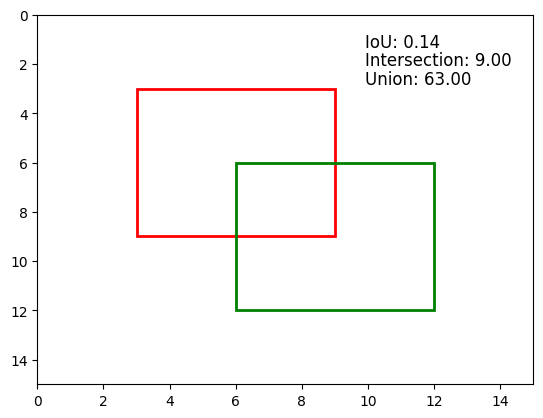

In [ ]:
boxes_preds = torch.tensor([[3, 3, 9, 9]])
boxes_labels = torch.tensor([[6, 6, 12, 12]])

# Вычисляем Intersection over Union
iou, intersection, union = intersection_over_union(boxes_preds, boxes_labels,
                                                   box_format='corners',
                                                   return_i_u=True)

# Создаем изображение для визуализации
fig, ax = plt.subplots(1)
ax.set_xlim(0, 15)
ax.set_ylim(0, 15)
ax.invert_yaxis()

# Рисуем прямоугольники
pred_rect = plt.Rectangle((boxes_preds[0][0], boxes_preds[0][1]), boxes_preds[0][2]-boxes_preds[0][0], boxes_preds[0][3]-boxes_preds[0][1], linewidth=2, edgecolor='r', facecolor='none')
label_rect = plt.Rectangle((boxes_labels[0][0], boxes_labels[0][1]), boxes_labels[0][2]-boxes_labels[0][0], boxes_labels[0][3]-boxes_labels[0][1], linewidth=2, edgecolor='g', facecolor='none')

# Добавляем прямоугольники на изображение
ax.add_patch(pred_rect)
ax.add_patch(label_rect)

# Добавляем текст с значениями Intersection over Union, пересечения и объединения боксов
ax.text(0.66, 0.95, f'IoU: {iou.item():.2f}', transform=ax.transAxes, fontsize=12, verticalalignment='top')
ax.text(0.66, 0.90, f'Intersection: {intersection.item():.2f}', transform=ax.transAxes, fontsize=12, verticalalignment='top')
ax.text(0.66, 0.85, f'Union: {union.item():.2f}', transform=ax.transAxes, fontsize=12, verticalalignment='top')

# Отображаем изображение
plt.show()

## Non-Maximum Suppression (NMS)

Хотим оставить из нескольких предсказанных боксов только самый лучший. Как его выбрать?

<img src="https://i.postimg.cc/vZrLm0Fh/maxresdefault.jpg" alt="drawing" width="1000"/>

На вход алгоритм NMS принимает предсказанные объекты (bboxes), порог уверенности (conf_threshold) и порог перекрытия (iou_threshold).

Предсказанные объекты содержат:
- class - метку класса
- scores - уверенность предсказания, что ббокс верный
- координаты бокса (bbox), который определяет его положение на изображении.

Алгоритм:
0. Инициализируем выходной список объектов пустым списком.
1. Удаляем объекты, которые не прошли порог уверенности.
2. Сортируем предсказанные объекты по убыванию их оценок уверенности.
3. Выбираем объект с самой высокой оценкой уверенности и добавляем его в окончательный список объектов.
4. Вычисляем IoU между выбранным объектом и остальными предсказанными объектами.
5. Удаляем все объекты, у которых перекрытие с выбранным объектом превышает заданный порог (обычно 0.5 или 0.7). Это позволяет удалить объекты, которые сильно перекрываются с уже выбранными объектами.
6. Повторяем шаги 3-5 для оставшихся предсказанных объектов, пока не останется объектов для обработки.
7. Возвращаем окончательный список объектов, которые прошли процесс подавления не-максимумов.


In [ ]:
def non_max_suppression(bboxes, iou_threshold, conf_threshold, box_format="corners"):
    """
    Does Non Max Suppression given bboxes

    Parameters:
        bboxes (list): list of lists containing all bboxes with each bboxes
          specified as [class_pred, prob_score, x1, y1, x2, y2]
        iou_threshold (float): threshold where predicted bboxes is correct
        conf_threshold (float): threshold to remove predicted bboxes (independent of IoU)
        box_format (str): "midpoint" or "corners" used to specify bboxes

    Returns:
        list: bboxes after performing NMS given a specific IoU threshold
    """

    assert type(bboxes) == list

    bboxes = [box for box in bboxes if box[1] > conf_threshold]
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
    bboxes_after_nms = []

    while bboxes:
        chosen_box = bboxes.pop(0)

        bboxes = [
            box
            for box in bboxes
            if box[0] != chosen_box[0]
            or intersection_over_union(
                torch.tensor(chosen_box[2:])[None, :],
                torch.tensor(box[2:])[None, :],
                box_format=box_format,
            ) < iou_threshold
        ]

        bboxes_after_nms.append(chosen_box)

    return bboxes_after_nms

### Проверка NMS

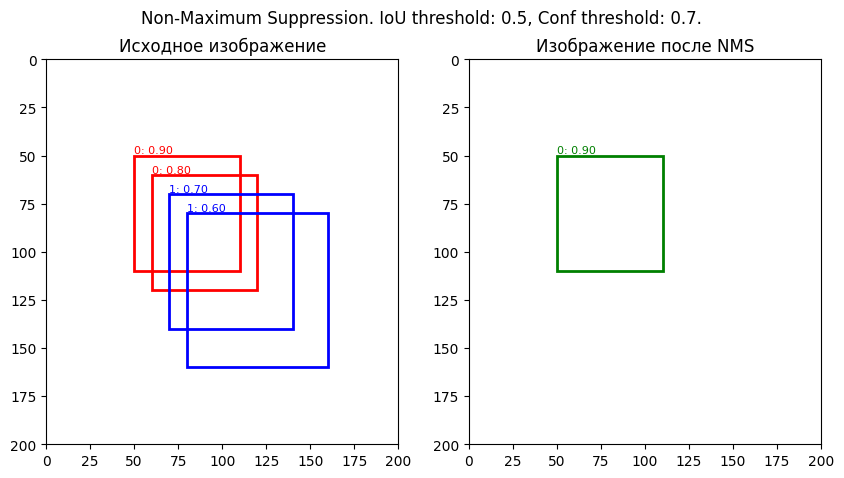

In [ ]:
# Создаем примеры ограничивающих прямоугольников (bbox)
boxes = [
    [0, 0.9, 50, 50, 110, 110],
    [0, 0.8, 60, 60, 120, 120],
    [1, 0.7, 70, 70, 140, 140],
    [1, 0.6, 80, 80, 160, 160],
]

# Задаем пороги для перекрытия (IoU) и уверенности (confidence)
iou_threshold = 0.5
conf_threshold = 0.7

# Применяем функцию non_max_suppression
selected_boxes = non_max_suppression(boxes, iou_threshold, conf_threshold)

# Создаем изображение для визуализации
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle(f'Non-Maximum Suppression. IoU threshold: {iou_threshold}, Conf threshold: {conf_threshold}.')

# Отображаем исходное изображение с исходными ограничивающими прямоугольниками
ax1.set_xlim(0, 200)
ax1.set_ylim(200, 0)  # Изменяем направление оси OY
ax1.set_title('Исходное изображение')
for box in boxes:
    class_pred, prob_score, x1, y1, x2, y2 = box
    color = 'r' if class_pred == 0 else 'b'  # Выбор цвета в зависимости от класса
    rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor=color, facecolor='none')
    ax1.add_patch(rect)
    ax1.text(x1, y1, f'{class_pred}: {prob_score:.2f}', color=color, fontsize=8, verticalalignment='bottom')  # Изменяем вертикальное выравнивание текста

# Отображаем отобранные прямоугольники на отдельном изображении
ax2.set_xlim(0, 200)
ax2.set_ylim(200, 0)  # Изменяем направление оси OY
ax2.set_title('Изображение после NMS')
for box in selected_boxes:
    class_pred, prob_score, x1, y1, x2, y2 = box
    color = 'g' if class_pred == 0 else 'y'  # Выбор цвета в зависимости от класса
    rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor=color, facecolor='none')
    ax2.add_patch(rect)
    ax2.text(x1, y1, f'{class_pred}: {prob_score:.2f}', color=color, fontsize=8, verticalalignment='bottom')  # Изменяем вертикальное выравнивание текста

# Отображаем изображения
plt.show()

## Датасет (preview)

### Pascal VOC (20 классов)

https://www.kaggle.com/datasets/734b7bcb7ef13a045cbdd007a3c19874c2586ed0b02b4afc86126e89d00af8d2?select=generate_csv.py

<img src="https://production-media.paperswithcode.com/datasets/9f6f02fc-a450-4adb-9af3-ef53ee016de6.jpg" alt="drawing" height="300"/>


In [ ]:
!pip install -q kaggle

In [ ]:
import os
kaggle_token = {"username":"izhanvarsky", "key":"e06d966b7ebc01cb2eaeec716e2d1cf0"}

os.environ['KAGGLE_USERNAME'] = kaggle_token['username']
os.environ['KAGGLE_KEY'] = kaggle_token['key']

In [ ]:
!kaggle datasets download -d aladdinpersson/pascalvoc-yolo

100% 4.30G/4.31G [03:27<00:00, 23.4MB/s]
100% 4.31G/4.31G [03:27<00:00, 22.3MB/s]


In [ ]:
!unzip -n -q ./pascalvoc-yolo.zip

In [ ]:
dataset_root = '/content'
images_dir = f"{dataset_root}/images"
labels_dir = f"{dataset_root}/labels"

In [ ]:
CLASS_NAMES = {
    0: 'aeroplane',
    1: 'bicycle',
    2: 'bird',
    3: 'boat',
    4: 'bottle',
    5: 'bus',
    6: 'car',
    7: 'cat',
    8: 'chair',
    9: 'cow',
    10: 'diningtable',
    11: 'dog',
    12: 'horse',
    13: 'motorbike',
    14: 'person',
    15: 'pottedplant',
    16: 'sheep',
    17: 'sofa',
    18: 'train',
    19: 'tvmonitor'
}

CLASS_COLORS = {
    0: (255, 0, 0),     # aeroplane - красный
    1: (0, 255, 0),     # bicycle - зеленый
    2: (0, 0, 255),     # bird - синий
    3: (255, 255, 0),   # boat - желтый
    4: (255, 0, 255),   # bottle - фиолетовый
    5: (0, 255, 255),   # bus - голубой
    6: (255, 255, 255), # car - белый
    7: (128, 0, 0),     # cat - темно-красный
    8: (0, 128, 0),     # chair - темно-зеленый
    9: (0, 0, 128),     # cow - темно-синий
    10: (128, 128, 0),  # diningtable - темно-желтый
    11: (128, 0, 128),  # dog - темно-фиолетовый
    12: (0, 128, 128),  # horse - темно-голубой
    13: (128, 128, 128),# motorbike - серый
    14: (64, 0, 0),     # person - темно-коричневый
    15: (0, 64, 0),     # pottedplant - темно-темно-зеленый
    16: (0, 0, 64),     # sheep - темно-темно-синий
    17: (64, 64, 0),    # sofa - темно-темно-желтый
    18: (64, 0, 64),    # train - темно-темно-фиолетовый
    19: (0, 64, 64)     # tvmonitor - темно-темно-голубой
}

#### Проверка картинок

In [ ]:
name = '000009'
img_path = f'{images_dir}/{name}.jpg'
label_path = f'{labels_dir}/{name}.txt'

In [ ]:
import cv2
import matplotlib.pyplot as plt

def draw_bounding_boxes(image_path, annotation_path):
    # Загрузка изображения
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Чтение файла разметки
    with open(annotation_path, 'r') as f:
        lines = f.readlines()

    # Отрисовка bounding boxes и имен классов
    for line in lines:
        class_id, x, y, width, height = map(float, line.split())
        x = int((x - width/2) * image.shape[1])
        y = int((y - height/2) * image.shape[0])
        width = int(width * image.shape[1])
        height = int(height * image.shape[0])

        # Отрисовка bounding box с соответствующим цветом класса
        class_color = CLASS_COLORS[int(class_id)]
        cv2.rectangle(image, (x, y), (x+width, y+height), class_color, 2)

        # Отрисовка имени класса
        class_name = CLASS_NAMES[int(class_id)]
        font_scale = 0.7
        font_thickness = 1
        text_size, _ = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, font_scale, font_thickness)
        text_x = x
        text_y = y - 10 if y >= 20 else y + 20
        cv2.rectangle(image, (text_x, text_y - text_size[1]), (text_x + text_size[0], text_y), class_color, -1)
        cv2.putText(image, class_name, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (255, 255, 255), font_thickness)

        # Отрисовка центра bounding box'а
        center_x = int(x + width / 2)
        center_y = int(y + height / 2)
        cv2.circle(image, (center_x, center_y), 3, (0, 255, 0), -1)

    # Отображение изображения с bounding boxes, именами классов и центрами
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

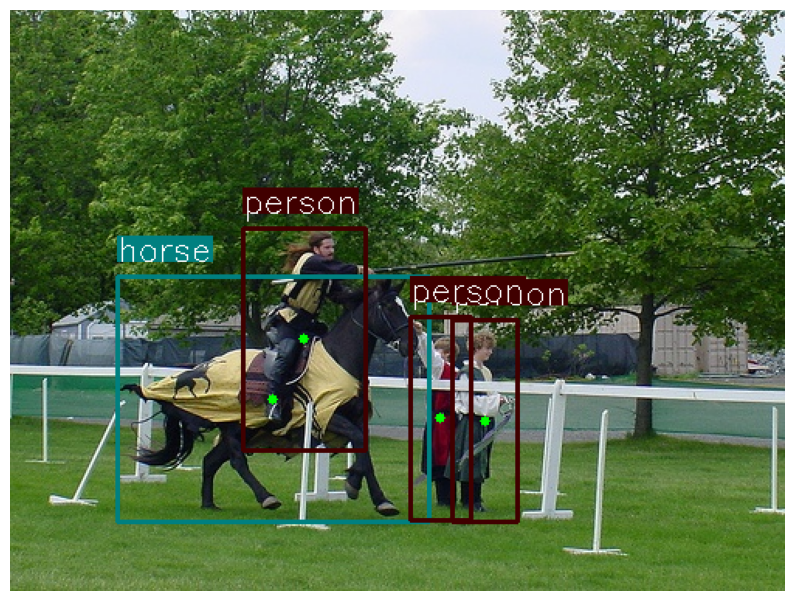

In [ ]:
draw_bounding_boxes(img_path, label_path)

## Модель - Yolov1

Paper: https://arxiv.org/pdf/1506.02640.pdf

### Идея

Разобьем входное изображение на сетку клеток (в статье используется 7х7)

<img src="https://qiita-user-contents.imgix.net/https%3A%2F%2Fqiita-image-store.s3.amazonaws.com%2F0%2F64334%2F71b61b30-4b9d-c24a-b7d9-b6f77117e0bb.png?ixlib=rb-4.0.0&auto=format&gif-q=60&q=75&w=1400&fit=max&s=6a46c6f5f9ac3671be044c9ed33dc641" alt="drawing" width="500"/>

Каждая клетка будет отвечать за центр одного объекта. Если в клетке нет центра объекта, то запишем ей вероятность объекта 0, иначе 1.

Какую еще информацию должна хранить клетка?

Есть разница, какую клетку мы рассматриваем - Ground Truth клетку (т.е. прямо из датасета) или клетку с предсказанной инфой.

Ground Truth клетка:
- one-hot encoding вектор, в котором 1 стоит у присутствующего класса
- вероятность, что центр объекта лежит в этой клетке (0 если нет, 1 если есть)
- позиция и размеры объекта. Задаются 4 числами: x, y - центр объекта, w и h - ширина и высота объекта. Все эти значения задаются относительно клетки. Т.е. x,y лежат в диапазоне 0..1, а w и h могут быть больше 1, если объект вылезает за границы клетки.

Т.е. размерность инфы для одной клетки = $num\_of\_classes + 5 = 25$.

Клетка с предсказанной инфой содержит всё то же самое, но мы можем предсказывать сразу несколько вариантов размеров объектов одного класса в клетке, а значит для каждого такого объекта нам нужно дополнительно выдавать его вероятность и его центр и координаты.

В нашем случае будем предсказывать сразу два бокса в клетке.

Итого: у предсказаний размерность выхода в клетке равна:

$num\_of\_classes + 5 * num\_of\_boxes = 30$

### Архитектура модели

В статье в качестве backbon'а авторами была написана собственная сеть, названная Darknet:

<img src="https://www.mdpi.com/ijgi/ijgi-08-00045/article_deploy/html/images/ijgi-08-00045-g003.png" alt="drawing" height="400"/>

Заметим, что выход сети - 7x7x30, т.к. используется разбиение на сетку 7x7, а каждая клетка в сетке предсказывает класс (20 чисел), и два объекта, у каждого есть вероятность его присутствия (1 число) и его позиция (4 числа - центр и ширина с высотой). Итого по 30 чисел на каждую клетку.


In [ ]:
from torch import nn

"""
Implementation of Yolo (v1) architecture
with slight modification with added BatchNorm.
"""

"""
Information about architecture config:
Tuple is structured by (kernel_size, filters, stride, padding)
"M" is simply maxpooling with stride 2x2 and kernel 2x2
List is structured by tuples and lastly int with number of repeats
"""

architecture_config = [
    (7, 64, 2, 3),
    "M",
    (3, 192, 1, 1),
    "M",
    (1, 128, 1, 0),
    (3, 256, 1, 1),
    (1, 256, 1, 0),
    (3, 512, 1, 1),
    "M",
    [(1, 256, 1, 0), (3, 512, 1, 1), 4],
    (1, 512, 1, 0),
    (3, 1024, 1, 1),
    "M",
    [(1, 512, 1, 0), (3, 1024, 1, 1), 2],
    (3, 1024, 1, 1),
    (3, 1024, 2, 1),
    (3, 1024, 1, 1),
    (3, 1024, 1, 1),
]


class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(CNNBlock, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, bias=False, **kwargs),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.1),
        )

    def forward(self, x):
        return self.layers(x)


class Yolov1(nn.Module):
    def __init__(self, in_channels=3, **kwargs):
        super(Yolov1, self).__init__()
        self.architecture = architecture_config
        self.in_channels = in_channels
        self.darknet = self._create_conv_layers(self.architecture)
        self.fcs = self._create_fcs(**kwargs)

    def forward(self, x):
        x = self.darknet(x)
        return self.fcs(x)

    def _create_conv_layers(self, architecture):
        layers = []
        in_channels = self.in_channels

        for x in architecture:
            if type(x) == tuple:
                layers += [
                    CNNBlock(
                        in_channels, x[1], kernel_size=x[0], stride=x[2], padding=x[3],
                    )
                ]
                in_channels = x[1]

            elif type(x) == str:
                layers += [nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))]

            elif type(x) == list:
                conv1 = x[0]
                conv2 = x[1]
                num_repeats = x[2]

                for _ in range(num_repeats):
                    layers += [
                        CNNBlock(
                            in_channels,
                            conv1[1],
                            kernel_size=conv1[0],
                            stride=conv1[2],
                            padding=conv1[3],
                        )
                    ]
                    layers += [
                        CNNBlock(
                            conv1[1],
                            conv2[1],
                            kernel_size=conv2[0],
                            stride=conv2[2],
                            padding=conv2[3],
                        )
                    ]
                    in_channels = conv2[1]

        return nn.Sequential(*layers)

    def _create_fcs(self, split_size, num_boxes, num_classes):
        S, B, C = split_size, num_boxes, num_classes

        # In original paper instead of 496 it should be 4096:
        return nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024 * S * S, 496),
            nn.LeakyReLU(0.1),
            nn.Linear(496, S * S * (C + B * 5)),
        )

#### Проверка модели

In [ ]:
grid_split_size = 7
num_boxes = 2
num_classes = len(CLASS_NAMES)
model = Yolov1(split_size=grid_split_size, num_boxes=num_boxes, num_classes=num_classes)

In [ ]:
input = torch.randn(2, 3, 448, 448)
res = model(input)
res.shape

torch.Size([2, 1470])

### Функция потери

Картинка из статьи:

<img src="https://bytepawn.com/images/yolov1_lf.JPG" alt="drawing" height="400"/>

In [ ]:
class YoloLoss(nn.Module):
    """
    Calculate the loss for yolo (v1) model
    """

    def __init__(self, S=7, B=2, C=20):
        super(YoloLoss, self).__init__()
        self.mse = nn.MSELoss(reduction="sum")

        """
        S is split size of image (in paper 7),
        B is number of boxes (in paper 2),
        C is number of classes (in paper and VOC dataset is 20),
        """
        self.S = S
        self.B = B
        self.C = C

        # These are from Yolo paper, signifying how much we should
        # pay loss for no object (noobj) and the box coordinates (coord)
        self.lambda_noobj = 0.5
        self.lambda_coord = 5

    def forward(self, predictions, target):
        # predictions are shaped (BATCH_SIZE, S*S*(C+B*5) when inputted
        predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B * 5)

        predicted_boxes1 = predictions[..., 21:25]
        predicted_boxes2 = predictions[..., 26:30]
        target_boxes = target[..., 21:25]
        # Calculate IoU for the two predicted bounding boxes with target bbox
        iou_b1 = intersection_over_union(predicted_boxes1, target_boxes)
        iou_b2 = intersection_over_union(predicted_boxes2, target_boxes)
        ious = torch.cat([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)], dim=0)

        # Take the box with highest IoU out of the two prediction
        # Note that bestbox will be indices of 0, 1 for which bbox was best
        bestbox = torch.argmax(ious, dim=0)
        exists_box = target[..., 20].unsqueeze(3)  # in paper this is Iobj_i

        # ======================== #
        #   FOR BOX COORDINATES    #
        # ======================== #

        # Set boxes with no object in them to 0. We only take out one of the two
        # predictions, which is the one with highest Iou calculated previously.
        box_predictions = exists_box * (
            (
                bestbox * predicted_boxes2
                + (1 - bestbox) * predicted_boxes1
            )
        )

        box_targets = exists_box * target_boxes

        # Take sqrt of width, height of boxes to ensure that
        box_predictions[..., 2:4] = torch.sign(box_predictions[..., 2:4]) * torch.sqrt(
            torch.abs(box_predictions[..., 2:4] + 1e-6)
        )
        box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])

        box_loss = self.mse(
            torch.flatten(box_predictions, end_dim=-2),
            torch.flatten(box_targets, end_dim=-2),
        )

        # ==================== #
        #   FOR OBJECT LOSS    #
        # ==================== #

        # pred_box is the confidence score for the bbox with highest IoU
        pred_box = (
            bestbox * predictions[..., 25:26] + (1 - bestbox) * predictions[..., 20:21]
        )

        object_loss = self.mse(
            torch.flatten(exists_box * pred_box),
            torch.flatten(exists_box * target[..., 20:21]),
        )

        # ======================= #
        #   FOR NO OBJECT LOSS    #
        # ======================= #

        no_object_loss = self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 20:21], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1),
        ) + self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 25:26], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1)
        )

        # ================== #
        #   FOR CLASS LOSS   #
        # ================== #

        class_loss = self.mse(
            torch.flatten(exists_box * predictions[..., :20], end_dim=-2,),
            torch.flatten(exists_box * target[..., :20], end_dim=-2,),
        )

        loss = (
            self.lambda_coord * box_loss  # first two rows in paper
            + object_loss  # third row in paper
            + self.lambda_noobj * no_object_loss  # forth row
            + class_loss  # fifth row
        )

        return loss

### Датасет

In [ ]:
import os
import pandas as pd
from PIL import Image


class VOCDataset(torch.utils.data.Dataset):
    def __init__(
        self, csv_file, img_dir, label_dir, S=7, B=2, C=20, transform=None,
    ):
        self.annotations = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform
        self.S = S
        self.B = B
        self.C = C

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        label_path = os.path.join(self.label_dir, self.annotations.iloc[index, 1])
        boxes = []
        with open(label_path) as f:
            for label in f.readlines():
                class_label, x, y, width, height = [
                    float(x) if float(x) != int(float(x)) else int(x)
                    for x in label.replace("\n", "").split()
                ]

                boxes.append([class_label, x, y, width, height])

        img_path = os.path.join(self.img_dir, self.annotations.iloc[index, 0])
        image = Image.open(img_path)
        boxes = torch.tensor(boxes)

        if self.transform:
            # image = self.transform(image)
            image, boxes = self.transform(image, boxes)

        # Convert To Cells
        label_matrix = torch.zeros((self.S, self.S, self.C + 5 * self.B))
        for box in boxes:
            class_label, x, y, width, height = box.tolist()
            class_label = int(class_label)

            # i,j represents the cell row and cell column
            i, j = int(self.S * y), int(self.S * x)
            x_cell, y_cell = self.S * x - j, self.S * y - i

            """
            Calculating the width and height of cell of bounding box,
            relative to the cell is done by the following, with
            width as the example:

            width_pixels = (width*self.image_width)
            cell_pixels = (self.image_width)

            Then to find the width relative to the cell is simply:
            width_pixels/cell_pixels, simplification leads to the
            formulas below.
            """
            width_cell, height_cell = (
                width * self.S,
                height * self.S,
            )

            # If no object already found for specific cell i,j
            # Note: This means we restrict to ONE object
            # per cell!
            if label_matrix[i, j, 20] == 0:
                # Set that there exists an object
                label_matrix[i, j, 20] = 1

                # Box coordinates
                box_coordinates = torch.tensor(
                    [x_cell, y_cell, width_cell, height_cell]
                )

                label_matrix[i, j, 21:25] = box_coordinates

                # Set one hot encoding for class_label
                label_matrix[i, j, class_label] = 1

        return image, label_matrix

In [ ]:
from torchvision import transforms

class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, bboxes):
        for t in self.transforms:
            img, bboxes = t(img), bboxes

        return img, bboxes


transform = Compose([transforms.Resize((448, 448)), transforms.ToTensor(),])

In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE = 16 # 64 in original paper
NUM_WORKERS = 2
PIN_MEMORY = True
IMG_DIR = images_dir
LABEL_DIR = labels_dir

train_dataset = VOCDataset(
    "100examples.csv",
    transform=transform,
    img_dir=IMG_DIR,
    label_dir=LABEL_DIR,
)

test_dataset = VOCDataset(
    "test.csv",
    transform=transform,
    img_dir=IMG_DIR,
    label_dir=LABEL_DIR,
)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=True,
    drop_last=True,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=True,
    drop_last=True,
)

### Обучение

In [ ]:
from tqdm import tqdm

seed = 123
torch.manual_seed(seed)

LEARNING_RATE = 2e-5
DEVICE = "cuda" if torch.cuda.is_available else "cpu"
EPOCHS = 200
LOAD_MODEL_FILE = "overfit.pth.tar"

In [ ]:
from torch import optim

model = Yolov1(split_size=7, num_boxes=2, num_classes=20).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = YoloLoss()

In [ ]:
def train():
    train_losses = []
    steps = []
    for epoch in range(1, EPOCHS + 1):
        print(f'Epoch: {epoch}/{EPOCHS} ...')

        loop = tqdm(train_loader, leave=True)
        mean_loss = []

        for batch_idx, (x, y) in enumerate(loop):
            x, y = x.to(DEVICE), y.to(DEVICE)
            out = model(x)
            loss = loss_fn(out, y)
            mean_loss.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loop.set_postfix(loss=loss.item())
        loss = sum(mean_loss) / len(mean_loss)
        print(f"Mean loss was {loss}")
        train_losses.append(loss)
        steps.append(epoch)
    plt.title('Train losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(steps, train_losses)
    plt.show()

Epoch: 1/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.40it/s, loss=805]


Mean loss was 981.5957946777344
Epoch: 2/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.37it/s, loss=788]


Mean loss was 612.5751037597656
Epoch: 3/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.39it/s, loss=537]


Mean loss was 491.8243103027344
Epoch: 4/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.28it/s, loss=295]


Mean loss was 398.6827646891276
Epoch: 5/200 ...


100%|██████████| 6/6 [00:03<00:00,  1.93it/s, loss=342]


Mean loss was 354.8928578694661
Epoch: 6/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.18it/s, loss=364]


Mean loss was 301.6998240152995
Epoch: 7/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.37it/s, loss=259]


Mean loss was 281.487553914388
Epoch: 8/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.36it/s, loss=269]


Mean loss was 235.1919174194336
Epoch: 9/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.30it/s, loss=222]


Mean loss was 208.15377553304037
Epoch: 10/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.06it/s, loss=220]


Mean loss was 182.53934224446616
Epoch: 11/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.28it/s, loss=152]


Mean loss was 169.59843953450522
Epoch: 12/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.26it/s, loss=84.9]


Mean loss was 144.55772145589194
Epoch: 13/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.17it/s, loss=143]


Mean loss was 133.32236353556314
Epoch: 14/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.25it/s, loss=104]


Mean loss was 123.84873326619466
Epoch: 15/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.01it/s, loss=122]


Mean loss was 114.97095235188802
Epoch: 16/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.26it/s, loss=114]


Mean loss was 103.77907435099284
Epoch: 17/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.28it/s, loss=89.6]


Mean loss was 110.70111465454102
Epoch: 18/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.29it/s, loss=119]


Mean loss was 89.08923021952312
Epoch: 19/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.04it/s, loss=59.6]


Mean loss was 93.28983306884766
Epoch: 20/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.28it/s, loss=82.2]


Mean loss was 88.01404317220052
Epoch: 21/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.25it/s, loss=102]


Mean loss was 84.11475372314453
Epoch: 22/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.04it/s, loss=61.9]


Mean loss was 84.35336303710938
Epoch: 23/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.22it/s, loss=51.8]


Mean loss was 74.0638001759847
Epoch: 24/200 ...


100%|██████████| 6/6 [00:03<00:00,  1.98it/s, loss=89.1]


Mean loss was 77.49180920918782
Epoch: 25/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.03it/s, loss=71.6]


Mean loss was 62.63647778828939
Epoch: 26/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.09it/s, loss=78.1]


Mean loss was 68.97223536173503
Epoch: 27/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.35it/s, loss=52.1]


Mean loss was 63.83064206441244
Epoch: 28/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.29it/s, loss=54.5]


Mean loss was 65.01032066345215
Epoch: 29/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.07it/s, loss=59.5]


Mean loss was 54.89810053507487
Epoch: 30/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.36it/s, loss=65.5]


Mean loss was 57.724676767985024
Epoch: 31/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.31it/s, loss=69.8]


Mean loss was 57.99559529622396
Epoch: 32/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.38it/s, loss=51.9]


Mean loss was 47.242636362711586
Epoch: 33/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.34it/s, loss=85.3]


Mean loss was 54.42169952392578
Epoch: 34/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.16it/s, loss=44.5]


Mean loss was 46.04910977681478
Epoch: 35/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.35it/s, loss=40.5]


Mean loss was 58.25678698221842
Epoch: 36/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.33it/s, loss=68.5]


Mean loss was 57.797681172688804
Epoch: 37/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.35it/s, loss=39.4]


Mean loss was 51.00302251180013
Epoch: 38/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.25it/s, loss=59.9]


Mean loss was 47.45355796813965
Epoch: 39/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.10it/s, loss=45]


Mean loss was 46.77132987976074
Epoch: 40/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.37it/s, loss=27.4]


Mean loss was 45.554538091023765
Epoch: 41/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.34it/s, loss=43.5]


Mean loss was 41.32443110148112
Epoch: 42/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.34it/s, loss=51.2]


Mean loss was 44.05402119954427
Epoch: 43/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.29it/s, loss=34.1]


Mean loss was 42.24863338470459
Epoch: 44/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.26it/s, loss=52.2]


Mean loss was 42.44289016723633
Epoch: 45/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.33it/s, loss=50.2]


Mean loss was 42.859402656555176
Epoch: 46/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.32it/s, loss=42.6]


Mean loss was 38.7055279413859
Epoch: 47/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.34it/s, loss=39]


Mean loss was 40.34056027730306
Epoch: 48/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.27it/s, loss=40.5]


Mean loss was 36.72263685862223
Epoch: 49/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.12it/s, loss=33.5]


Mean loss was 34.97183036804199
Epoch: 50/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.31it/s, loss=34.8]


Mean loss was 36.639387448628746
Epoch: 51/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.27it/s, loss=23.8]


Mean loss was 39.739017486572266
Epoch: 52/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.09it/s, loss=54.1]


Mean loss was 37.02993933359782
Epoch: 53/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.28it/s, loss=47.5]


Mean loss was 47.29766019185384
Epoch: 54/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.08it/s, loss=52.2]


Mean loss was 45.56696732838949
Epoch: 55/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.34it/s, loss=53.9]


Mean loss was 43.618157386779785
Epoch: 56/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.37it/s, loss=63]


Mean loss was 47.55301475524902
Epoch: 57/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.34it/s, loss=42.4]


Mean loss was 36.111631075541176
Epoch: 58/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.27it/s, loss=31.8]


Mean loss was 34.48451042175293
Epoch: 59/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.12it/s, loss=108]


Mean loss was 45.85657978057861
Epoch: 60/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.33it/s, loss=51]


Mean loss was 34.60881201426188
Epoch: 61/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.31it/s, loss=50.9]


Mean loss was 34.02144877115885
Epoch: 62/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.24it/s, loss=29.9]


Mean loss was 33.855759620666504
Epoch: 63/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.10it/s, loss=27.6]


Mean loss was 32.510025342305504
Epoch: 64/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.31it/s, loss=29.2]


Mean loss was 29.68786684672038
Epoch: 65/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.34it/s, loss=27.6]


Mean loss was 27.477784792582195
Epoch: 66/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.35it/s, loss=34]


Mean loss was 29.908243815104168
Epoch: 67/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.35it/s, loss=41.8]


Mean loss was 27.868133703867596
Epoch: 68/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.09it/s, loss=35]


Mean loss was 30.187419891357422
Epoch: 69/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.34it/s, loss=29.1]


Mean loss was 27.113403002421062
Epoch: 70/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.07it/s, loss=24.1]


Mean loss was 26.745758692423504
Epoch: 71/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.09it/s, loss=26.3]


Mean loss was 26.283658981323242
Epoch: 72/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.29it/s, loss=29.5]


Mean loss was 24.41010856628418
Epoch: 73/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.03it/s, loss=25]


Mean loss was 24.59069569905599
Epoch: 74/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.35it/s, loss=16.4]


Mean loss was 32.87076759338379
Epoch: 75/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.32it/s, loss=34.1]


Mean loss was 34.400011698404946
Epoch: 76/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.36it/s, loss=20.8]


Mean loss was 29.716036160786945
Epoch: 77/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.30it/s, loss=28.9]


Mean loss was 37.2706724802653
Epoch: 78/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.18it/s, loss=35.6]


Mean loss was 28.852235158284504
Epoch: 79/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.36it/s, loss=39]


Mean loss was 41.634803771972656
Epoch: 80/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.34it/s, loss=24.7]


Mean loss was 29.426612218221027
Epoch: 81/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.35it/s, loss=37.1]


Mean loss was 27.540383338928223
Epoch: 82/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.31it/s, loss=41.3]


Mean loss was 29.37188784281413
Epoch: 83/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.09it/s, loss=31]


Mean loss was 25.591107845306396
Epoch: 84/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.34it/s, loss=27]


Mean loss was 22.132661819458008
Epoch: 85/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.34it/s, loss=25.7]


Mean loss was 21.261847496032715
Epoch: 86/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.31it/s, loss=16.5]


Mean loss was 22.39819622039795
Epoch: 87/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.30it/s, loss=22.2]


Mean loss was 22.85873031616211
Epoch: 88/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.03it/s, loss=25.5]


Mean loss was 24.16391404469808
Epoch: 89/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.35it/s, loss=35.8]


Mean loss was 27.071505864461262
Epoch: 90/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.32it/s, loss=26.6]


Mean loss was 23.25811703999837
Epoch: 91/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.15it/s, loss=23.1]


Mean loss was 19.37534236907959
Epoch: 92/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.18it/s, loss=21.1]


Mean loss was 20.285010655721027
Epoch: 93/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.35it/s, loss=15.4]


Mean loss was 19.37989854812622
Epoch: 94/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.33it/s, loss=20.4]


Mean loss was 19.03470579783122
Epoch: 95/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.37it/s, loss=12.9]


Mean loss was 18.782304763793945
Epoch: 96/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.33it/s, loss=16.9]


Mean loss was 19.606887976328533
Epoch: 97/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.10it/s, loss=19]


Mean loss was 18.71935510635376
Epoch: 98/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.34it/s, loss=22.6]


Mean loss was 18.12213198343913
Epoch: 99/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.33it/s, loss=22.6]


Mean loss was 19.9645676612854
Epoch: 100/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.34it/s, loss=19.4]


Mean loss was 17.77683115005493
Epoch: 101/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.32it/s, loss=20.6]


Mean loss was 17.426279067993164
Epoch: 102/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.04it/s, loss=13.2]


Mean loss was 17.390202204386394
Epoch: 103/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.30it/s, loss=14.1]


Mean loss was 16.6971271832784
Epoch: 104/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.37it/s, loss=14]


Mean loss was 16.063408374786377
Epoch: 105/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.34it/s, loss=21.7]


Mean loss was 17.71966091791789
Epoch: 106/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.30it/s, loss=15.4]


Mean loss was 14.504045168558756
Epoch: 107/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.08it/s, loss=20.1]


Mean loss was 14.450115203857422
Epoch: 108/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.33it/s, loss=11.6]


Mean loss was 14.91196060180664
Epoch: 109/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.37it/s, loss=17.9]


Mean loss was 14.931766192118326
Epoch: 110/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.32it/s, loss=19.4]


Mean loss was 14.77229897181193
Epoch: 111/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.29it/s, loss=10.4]


Mean loss was 13.515926678975424
Epoch: 112/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.12it/s, loss=14.4]


Mean loss was 14.060384432474772
Epoch: 113/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.33it/s, loss=13.9]


Mean loss was 12.348600069681803
Epoch: 114/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.34it/s, loss=13.6]


Mean loss was 14.103455384572348
Epoch: 115/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.33it/s, loss=9.83]


Mean loss was 13.942313035329184
Epoch: 116/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.30it/s, loss=19]


Mean loss was 17.434740384419758
Epoch: 117/200 ...


100%|██████████| 6/6 [00:03<00:00,  2.00it/s, loss=20.5]


Mean loss was 15.803170680999756
Epoch: 118/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.08it/s, loss=11.2]


Mean loss was 17.142661253611248
Epoch: 119/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.11it/s, loss=16.2]


Mean loss was 17.817689736684162
Epoch: 120/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.39it/s, loss=12.8]


Mean loss was 16.282753626505535
Epoch: 121/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.31it/s, loss=11.3]


Mean loss was 20.764494101206463
Epoch: 122/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.07it/s, loss=18.1]


Mean loss was 16.765789031982422
Epoch: 123/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.37it/s, loss=17]


Mean loss was 16.397387504577637
Epoch: 124/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.35it/s, loss=10.5]


Mean loss was 15.868137200673422
Epoch: 125/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.36it/s, loss=13.5]


Mean loss was 15.699758052825928
Epoch: 126/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.30it/s, loss=14.7]


Mean loss was 15.14078680674235
Epoch: 127/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.14it/s, loss=12.7]


Mean loss was 14.795387427012125
Epoch: 128/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.37it/s, loss=28.3]


Mean loss was 16.470162232716877
Epoch: 129/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.33it/s, loss=11.3]


Mean loss was 14.111207644144693
Epoch: 130/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.36it/s, loss=14.1]


Mean loss was 15.447178840637207
Epoch: 131/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.28it/s, loss=15.2]


Mean loss was 13.011965115865072
Epoch: 132/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.08it/s, loss=11.3]


Mean loss was 12.24616003036499
Epoch: 133/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.30it/s, loss=11]


Mean loss was 14.17817727724711
Epoch: 134/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.35it/s, loss=12.6]


Mean loss was 12.569709300994873
Epoch: 135/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.36it/s, loss=11.7]


Mean loss was 12.88903252283732
Epoch: 136/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.22it/s, loss=16.1]


Mean loss was 14.46986198425293
Epoch: 137/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.19it/s, loss=23.3]


Mean loss was 14.294453461964926
Epoch: 138/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.36it/s, loss=11.8]


Mean loss was 13.829422950744629
Epoch: 139/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.38it/s, loss=10.8]


Mean loss was 14.00286308924357
Epoch: 140/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.33it/s, loss=8.78]


Mean loss was 13.013344446818033
Epoch: 141/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.29it/s, loss=10.3]


Mean loss was 13.249937216440836
Epoch: 142/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.06it/s, loss=15.2]


Mean loss was 13.256433327992758
Epoch: 143/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.36it/s, loss=10.1]


Mean loss was 12.902448972066244
Epoch: 144/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.34it/s, loss=9.97]


Mean loss was 11.960892836252848
Epoch: 145/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.31it/s, loss=16.5]


Mean loss was 11.690000375111898
Epoch: 146/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.32it/s, loss=12.5]


Mean loss was 10.431674321492514
Epoch: 147/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.10it/s, loss=11.5]


Mean loss was 9.341700394948324
Epoch: 148/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.32it/s, loss=13.3]


Mean loss was 11.249658266703287
Epoch: 149/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.36it/s, loss=11.6]


Mean loss was 10.874080419540405
Epoch: 150/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.34it/s, loss=11.5]


Mean loss was 13.326178073883057
Epoch: 151/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.21it/s, loss=9.7]


Mean loss was 12.95369815826416
Epoch: 152/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.12it/s, loss=10.1]


Mean loss was 12.992498874664307
Epoch: 153/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.31it/s, loss=10.5]


Mean loss was 10.650649070739746
Epoch: 154/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.29it/s, loss=16.3]


Mean loss was 12.015492598215738
Epoch: 155/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.31it/s, loss=17.2]


Mean loss was 11.477633714675903
Epoch: 156/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.12it/s, loss=8.81]


Mean loss was 12.323081016540527
Epoch: 157/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.33it/s, loss=12.2]


Mean loss was 10.157430330912272
Epoch: 158/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.32it/s, loss=16.8]


Mean loss was 10.256486892700195
Epoch: 159/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.36it/s, loss=11.6]


Mean loss was 12.293375651041666
Epoch: 160/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.30it/s, loss=7.87]


Mean loss was 11.443865060806274
Epoch: 161/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.06it/s, loss=13]


Mean loss was 11.29327392578125
Epoch: 162/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.33it/s, loss=11.6]


Mean loss was 12.6669872601827
Epoch: 163/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.30it/s, loss=18.5]


Mean loss was 14.17668890953064
Epoch: 164/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.31it/s, loss=15.8]


Mean loss was 13.077358404795328
Epoch: 165/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.23it/s, loss=23]


Mean loss was 12.732417821884155
Epoch: 166/200 ...


100%|██████████| 6/6 [00:03<00:00,  1.98it/s, loss=11]


Mean loss was 11.054259300231934
Epoch: 167/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.04it/s, loss=14.2]


Mean loss was 13.062837600708008
Epoch: 168/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.31it/s, loss=7.14]


Mean loss was 10.242668867111206
Epoch: 169/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.34it/s, loss=13.6]


Mean loss was 10.832754691441854
Epoch: 170/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.10it/s, loss=9.26]


Mean loss was 10.061579386393229
Epoch: 171/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.05it/s, loss=12.1]


Mean loss was 10.276983896891275
Epoch: 172/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.34it/s, loss=7.61]


Mean loss was 7.982964277267456
Epoch: 173/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.36it/s, loss=12.5]


Mean loss was 8.984026988347372
Epoch: 174/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.35it/s, loss=11.5]


Mean loss was 10.415139357248941
Epoch: 175/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.23it/s, loss=8.6]


Mean loss was 10.697946707407633
Epoch: 176/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.06it/s, loss=8.99]


Mean loss was 9.447992006937662
Epoch: 177/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.33it/s, loss=16.8]


Mean loss was 9.911201477050781
Epoch: 178/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.33it/s, loss=9.41]


Mean loss was 8.272069136301676
Epoch: 179/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.36it/s, loss=9.65]


Mean loss was 9.411322434743246
Epoch: 180/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.27it/s, loss=7.99]


Mean loss was 8.54082957903544
Epoch: 181/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.06it/s, loss=9.86]


Mean loss was 8.553900877634684
Epoch: 182/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.36it/s, loss=11.8]


Mean loss was 9.002055803934732
Epoch: 183/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.35it/s, loss=7.8]


Mean loss was 8.087634007136026
Epoch: 184/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.37it/s, loss=10.1]


Mean loss was 8.431112925211588
Epoch: 185/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.33it/s, loss=8.81]


Mean loss was 8.927256345748901
Epoch: 186/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.00it/s, loss=10.1]


Mean loss was 9.270344257354736
Epoch: 187/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.35it/s, loss=7.49]


Mean loss was 9.419122775395712
Epoch: 188/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.35it/s, loss=17.4]


Mean loss was 12.022600332895914
Epoch: 189/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.33it/s, loss=8.08]


Mean loss was 12.646211783091227
Epoch: 190/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.31it/s, loss=8.12]


Mean loss was 13.861480077107748
Epoch: 191/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.20it/s, loss=12.9]


Mean loss was 13.213540077209473
Epoch: 192/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.34it/s, loss=10.5]


Mean loss was 11.551440397898356
Epoch: 193/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.36it/s, loss=11.5]


Mean loss was 11.708191553751627
Epoch: 194/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.34it/s, loss=11.3]


Mean loss was 10.804567019144693
Epoch: 195/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.28it/s, loss=15.2]


Mean loss was 13.127400239308676
Epoch: 196/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.02it/s, loss=13.2]


Mean loss was 13.86321465174357
Epoch: 197/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.35it/s, loss=9.73]


Mean loss was 11.239439010620117
Epoch: 198/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.33it/s, loss=12.5]


Mean loss was 10.575808048248291
Epoch: 199/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.35it/s, loss=14.9]


Mean loss was 11.484362920125326
Epoch: 200/200 ...


100%|██████████| 6/6 [00:02<00:00,  2.31it/s, loss=5.07]


Mean loss was 12.407267491022745


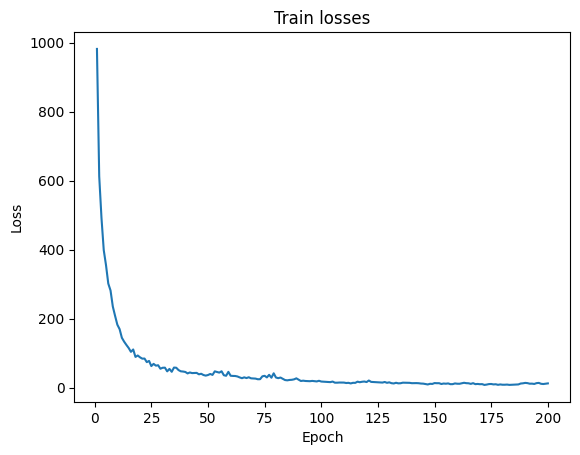

In [ ]:
train()

#### Тестирование

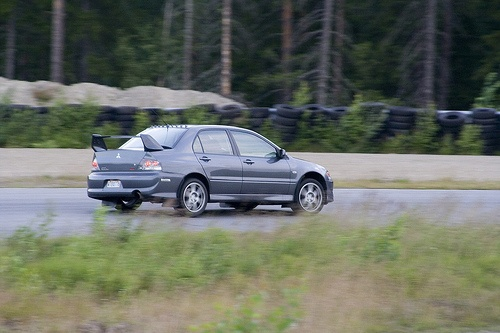

In [ ]:
test_img_path = './images/000026.jpg'
pil_img = Image.open(test_img_path)
pil_img

In [ ]:
def convert_cellboxes(predictions, S=7):
    """
    Converts bounding boxes output from Yolo with
    an image split size of S into entire image ratios
    rather than relative to cell ratios. Tried to do this
    vectorized, but this resulted in quite difficult to read
    code... Use as a black box? Or implement a more intuitive,
    using 2 for loops iterating range(S) and convert them one
    by one, resulting in a slower but more readable implementation.
    """

    predictions = predictions.to("cpu")
    batch_size = predictions.shape[0]
    predictions = predictions.reshape(batch_size, 7, 7, 30)
    bboxes1 = predictions[..., 21:25]
    bboxes2 = predictions[..., 26:30]
    scores = torch.cat(
        (predictions[..., 20].unsqueeze(0), predictions[..., 25].unsqueeze(0)), dim=0
    )
    best_box = scores.argmax(0).unsqueeze(-1)
    best_boxes = bboxes1 * (1 - best_box) + best_box * bboxes2
    cell_indices = torch.arange(7).repeat(batch_size, 7, 1).unsqueeze(-1)
    x = 1 / S * (best_boxes[..., :1] + cell_indices)
    y = 1 / S * (best_boxes[..., 1:2] + cell_indices.permute(0, 2, 1, 3))
    w_y = 1 / S * best_boxes[..., 2:4]
    converted_bboxes = torch.cat((x, y, w_y), dim=-1)
    predicted_class = predictions[..., :20].argmax(-1).unsqueeze(-1)
    best_confidence = torch.max(predictions[..., 20], predictions[..., 25]).unsqueeze(
        -1
    )
    converted_preds = torch.cat(
        (predicted_class, best_confidence, converted_bboxes), dim=-1
    )

    return converted_preds


def cellboxes_to_boxes(out, S=7):
    converted_pred = convert_cellboxes(out).reshape(out.shape[0], S * S, -1)
    converted_pred[..., 0] = converted_pred[..., 0].long()
    all_bboxes = []

    for ex_idx in range(out.shape[0]):
        bboxes = []

        for bbox_idx in range(S * S):
            bboxes.append([x.item() for x in converted_pred[ex_idx, bbox_idx, :]])
        all_bboxes.append(bboxes)

    return all_bboxes

In [ ]:
image, _ = transform(pil_img, None)
image = image.to(DEVICE)
out = model(image[None, :])

In [ ]:
out.shape

torch.Size([1, 1470])

In [ ]:
bboxes = cellboxes_to_boxes(out)[0]

In [ ]:
np.array(bboxes).shape

(49, 6)

In [ ]:
bboxes[0]

[13.0,
 0.130453959107399,
 0.3104766607284546,
 0.14065878093242645,
 -0.1018332988023758,
 -0.11291463673114777]

In [ ]:
nms_bboxes = non_max_suppression(bboxes, iou_threshold=0.5, conf_threshold=0.3, box_format="midpoint")
nms_bboxes

[[6.0,
  0.4460639953613281,
  0.3955394923686981,
  0.5065496563911438,
  0.4542244076728821,
  0.428861141204834]]

In [ ]:
from PIL import Image, ImageDraw

def draw_bounding_boxes(image, predictions):
    image = image.copy()
    # Создание объекта для рисования на изображении
    draw = ImageDraw.Draw(image)

    # Проход по каждому предсказанию и рисование bounding box'а
    for prediction in predictions:
        class_index, confidence, center_x, center_y, width, height = prediction

        # Получение имени класса и цвета по индексу
        class_name = CLASS_NAMES[class_index]
        color = CLASS_COLORS[class_index]

        # Вычисление координат bounding box'а
        left = (center_x - width/2) * image.width
        top = (center_y - height/2) * image.height
        right = (center_x + width/2) * image.width
        bottom = (center_y + height/2) * image.height

        # Рисование bounding box'а с соответствующим цветом и надписью класса
        draw.rectangle([left, top, right, bottom], outline=color)
        draw.text((left, top), class_name, fill=color)

    # Отображение изображения с bounding box'ами
    display(image)

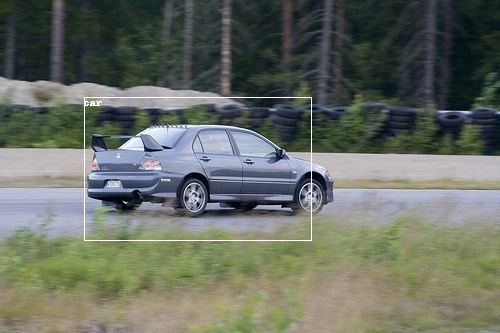

In [ ]:
draw_bounding_boxes(pil_img, nms_bboxes)